# Regression Analysis - Modularity

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from itertools import permutations

In [19]:
imm_comp_df = pd.read_csv('00_IMM_timeperiods_comparison.csv')
clim_comp_df = pd.read_csv('00_CLIM_timeperiods_comparison.csv')
trends = pd.read_csv('Gtrends_imm_clim_2017_2019.csv')
poll = pd.read_csv('FR_parties_seats_polls_classes_2017-2019.csv')
corr = pd.read_csv('5_media_party_class_salience_CORRELATION_across_time.csv')
df = pd.read_csv('main_dataset.csv')

In [20]:
leanings = ['left', 'centre-left', 'centre', 'centre-right', 'right']
all_permutations = []
for element in leanings:
    all_permutations.append((element, element))
all_permutations.extend(list(permutations(leanings, 2)))

In [21]:
imm_comp_df.head()

,time_period,start_date,end_date,nodes_number,edges_number,density,avg_degree,compactness,modularity,communities_number
0,1,2017-01-01,2017-01-15,25,24,0.080000,1.920000,0.335000,0.502604,6
1,2,2017-01-15,2017-01-29,20,19,0.100000,1.900000,0.469298,0.447368,3
2,3,2017-01-29,2017-02-12,24,26,0.094203,2.166667,0.407186,0.500000,6
3,4,2017-02-12,2017-02-26,16,13,0.108333,1.625000,0.233333,0.606509,4
4,5,2017-02-26,2017-03-12,13,11,0.141026,1.692308,0.318376,0.533058,3


Create "same side [right \ left]", "opposite side", "centre" categories for the regressions

In [22]:
corr['side'] = None

for index, row in corr.iterrows():
    if ('left' in row['media_leaning']) and ('left' in row['party_leaning']):
        corr.at[index, 'side'] = 'same_left'
    elif ('right' in row['media_leaning']) and ('right' in row['party_leaning']): 
        corr.at[index, 'side'] = 'same_right'
    elif 'centre' in row['media_leaning'] or 'centre' in row['party_leaning']: 
        corr.at[index, 'side'] = 'centre'
    else: 
        corr.at[index, 'side'] = 'opposite'

In [23]:
corr.dropna(inplace = True)

Prepare data for the regressions – we hereby create one dataset with all the variables that we need for immigration and one for climate change

Step 1 - Define functions we will use

In [24]:
def subset_df_salience(topic):
    temp_df = corr[['time_period','media_leaning',f'{topic}_media_salience',f'{topic}_party_salience']]
    new_df = pd.DataFrame()
    
    for period in list(temp_df['time_period'].unique()): 
        temp_dic = {}
        temp_dic = {'time_period' : [period]}
    
        for leaning in leanings:
            filtered_rows = temp_df[(temp_df['media_leaning'] == leaning) & (temp_df['time_period'] == period)]
            if not filtered_rows.empty:
                
                media = filtered_rows[f'{topic}_media_salience'].values[0]
                party = filtered_rows[f'{topic}_party_salience'].values[0]
                temp_dic.update({f'{leaning}_media_salience' : [media],
                                f'{leaning}_party_salience' : [party]})    
            
        row = pd.DataFrame(temp_dic)
        new_df = pd.concat([new_df, row], ignore_index = True)
        
    new_df.sort_values(by='time_period', inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    
    return new_df

def subset_df_alignment(topic):
    temp_df = corr[['time_period','start_date','end_date','media_leaning','party_leaning',
                  f'{topic}_alignment',f'{topic}_media_salience',f'{topic}_party_salience']]

    new_df = pd.DataFrame()
    
    for period in list(imm_comp_df['time_period'].unique()): 
        temp_dic = {}
        temp_dic = {'time_period' : [period]}

        for pair in all_permutations:
            leaning_1 = pair[0]
            leaning_2 = pair[1]
            filtered_rows = temp_df[((temp_df['media_leaning'] == leaning_1) | (temp_df['party_leaning'] == leaning_2)) & (temp_df['time_period'] == period) ]
            
            if not filtered_rows.empty:
                value = filtered_rows[f'{topic}_alignment'].values[0]
                temp_dic.update({f'{leaning_1}_{leaning_2}_alignment' : [value]})
            
            else: 
                value = None
                temp_dic.update({f'{leaning_1}_{leaning_2}_alignment' : [value]})
                
        row = pd.DataFrame(temp_dic)
        new_df = pd.concat([new_df, row], ignore_index = True)
    
    new_df.sort_values(by='time_period', inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    
    return new_df


def subset_df_alignment_side(topic):
    temp_df = corr[['time_period','start_date','end_date','media_leaning','party_leaning','side',
                  f'{topic}_alignment',f'{topic}_media_salience',f'{topic}_party_salience']]

    new_df = pd.DataFrame()
    
    for period in list(imm_comp_df['time_period'].unique()): 
        temp_dic = {}
        temp_dic = {'time_period' : [period]}

        for side in list(temp_df['side'].unique()):
            filtered_rows = temp_df[(temp_df['side'] == side) & (temp_df['time_period'] == period)]
            
            if not filtered_rows.empty:
                value = filtered_rows[f'{topic}_alignment'].mean()
                temp_dic.update({f'{side}_alignment' : [value]})
            
            else: 
                value = None
                temp_dic.update({f'{side}_alignment' : [value]})
                
        row = pd.DataFrame(temp_dic)
        new_df = pd.concat([new_df, row], ignore_index = True)
    
    new_df.sort_values(by='time_period', inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    
    return new_df

def subset_df_politics():
    new_df = pd.DataFrame()
    
    for period in list(poll['time_period'].unique()): 
        temp_dic = {}
        temp_dic = {'time_period' : [period]}
    
        for leaning in leanings:
            filtered_rows = poll[(poll['leaning'] == leaning) & (poll['time_period'] == period)]
            if not filtered_rows.empty:
                    
                ep = filtered_rows['ep_share'].values[0]
                parliament = filtered_rows['parliament_share'].values[0]
                polls = filtered_rows['poll_value'].values[0]
                temp_dic.update({f'{leaning}_ep' : [ep],
                                f'{leaning}_parliament' : [parliament],
                                f'{leaning}_poll' : [polls]})    
            
        row = pd.DataFrame(temp_dic)
        new_df = pd.concat([new_df, row], ignore_index = True)
        
    new_df.sort_values(by='time_period', inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    
    return new_df

Step 2 - Prep the data for salience in media and parties

In [25]:
salience_imm = subset_df_salience('imm')
salience_clim = subset_df_salience('clim')

Step 3 - Prep data for alignment

In [26]:
align_imm_lean = subset_df_alignment('imm')
align_clim_lean = subset_df_alignment('clim')

In [27]:
align_imm_side = subset_df_alignment_side('imm')
align_clim_side = subset_df_alignment_side('clim')

In [28]:
imm = pd.merge(imm_comp_df, align_imm_side, on='time_period', how='inner')
clim = pd.merge(clim_comp_df, align_clim_side, on='time_period', how='inner')

Step 3 – prep polling data and parliamentary seat shares

In [29]:
poll=poll.groupby(['leaning','time_period'])[['poll_value','ep_share','parliament_share']].sum().reset_index()    
poll=subset_df_politics()
poll['time_period'] = poll['time_period'].apply(int)

Step 4 - map everything into one single dataset

In [30]:
#media and party salience
imm['media_salience'] = imm['time_period'].map(df.groupby('time_period')['imm_media_salience'].mean())
imm['party_salience'] = imm['time_period'].map(df.groupby('time_period')['imm_party_salience'].mean())

clim['media_salience'] = clim['time_period'].map(df.groupby('time_period')['clim_media_salience'].mean())
clim['party_salience'] = clim['time_period'].map(df.groupby('time_period')['clim_party_salience'].mean())

#Google trends
clim = pd.merge(clim,trends[['time_period','gtrend_salience_clim']],on='time_period')
imm = pd.merge(imm,trends[['time_period','gtrend_salience_imm']],on='time_period')

#political stats
for column in poll.loc[:, poll.columns != 'time_period'].columns:
    imm[column] = imm['time_period'].map(poll.set_index('time_period')[column])
    clim[column] = clim['time_period'].map(poll.set_index('time_period')[column])

#network stats
ntk_stats_imm = pd.DataFrame(df[['time_period','imm_modularity','imm_nodes_number','imm_edges_number']].groupby('time_period').mean()[['imm_modularity','imm_nodes_number','imm_edges_number']].reset_index())
ntk_stats_clim = pd.DataFrame(df[['time_period','clim_modularity','clim_nodes_number','clim_edges_number']].groupby('time_period').mean()[['clim_modularity','clim_nodes_number','clim_edges_number']].reset_index())

imm['nodes_number'] = imm.time_period.map(ntk_stats_imm.set_index('time_period')['imm_nodes_number'])
imm['edges_number']= imm.time_period.map(ntk_stats_imm.set_index('time_period')['imm_edges_number'])
imm['modularity']= imm.time_period.map(ntk_stats_imm.set_index('time_period')['imm_modularity'])

clim['nodes_number']= clim.time_period.map(ntk_stats_clim.set_index('time_period')['clim_nodes_number'])
clim['edges_number']= clim.time_period.map(ntk_stats_clim.set_index('time_period')['clim_edges_number'])
clim['modularity']= clim.time_period.map(ntk_stats_clim.set_index('time_period')['clim_modularity'])

imm.fillna(0,inplace=True)
clim.fillna(0, inplace=True)

These are the two datasets we will use for the regressions.

In [31]:
clim.head()

,time_period,start_date,end_date,nodes_number,edges_number,density,avg_degree,compactness,modularity,communities_number,...,centre_poll,centre-right_ep,centre-right_parliament,centre-right_poll,right_ep,right_parliament,right_poll,centre-left_ep,centre-left_parliament,centre-left_poll
0,1,2017-01-01,2017-01-15,34.0,38.0,0.067736,2.235294,0.350004,0.553670,6,...,0.0,0.27027,0.336222,0.245000,0.324324,0.003466,0.261250,0.108108,0.006932,0.132500
1,2,2017-01-15,2017-01-29,34.0,43.0,0.076649,2.529412,0.366650,0.496755,5,...,0.0,0.27027,0.336222,0.245000,0.324324,0.003466,0.261250,0.054054,0.003466,0.066250
2,3,2017-01-29,2017-02-12,28.0,34.0,0.089947,2.428571,0.399868,0.491782,5,...,0.0,0.27027,0.336222,0.180714,0.324324,0.003466,0.258571,0.054054,0.003466,0.052857
3,4,2017-02-12,2017-02-26,22.0,24.0,0.103896,2.181818,0.513709,0.311632,4,...,0.0,0.27027,0.336222,0.194091,0.324324,0.003466,0.260000,0.054054,0.003466,0.053333
4,5,2017-02-26,2017-03-12,25.0,38.0,0.126667,3.040000,0.505278,0.337604,4,...,0.0,0.27027,0.336222,0.191667,0.324324,0.003466,0.265000,0.054054,0.003466,0.053333


In [33]:
clim.columns

Index(['time_period', 'start_date', 'end_date', 'nodes_number', 'edges_number',
       'density', 'avg_degree', 'compactness', 'modularity',
       'communities_number', 'same_left_alignment', 'centre_alignment',
       'same_right_alignment', 'opposite_alignment', 'media_salience',
       'party_salience', 'gtrend_salience_clim', 'left_ep', 'left_parliament',
       'left_poll', 'centre_ep', 'centre_parliament', 'centre_poll',
       'centre-right_ep', 'centre-right_parliament', 'centre-right_poll',
       'right_ep', 'right_parliament', 'right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll'],
      dtype='object')

In [34]:
imm.head()

,time_period,start_date,end_date,nodes_number,edges_number,density,avg_degree,compactness,modularity,communities_number,...,centre_poll,centre-right_ep,centre-right_parliament,centre-right_poll,right_ep,right_parliament,right_poll,centre-left_ep,centre-left_parliament,centre-left_poll
0,1,2017-01-01,2017-01-15,25.0,24.0,0.080000,1.920000,0.335000,0.502604,6,...,0.0,0.27027,0.336222,0.245000,0.324324,0.003466,0.261250,0.108108,0.006932,0.132500
1,2,2017-01-15,2017-01-29,20.0,19.0,0.100000,1.900000,0.469298,0.441828,3,...,0.0,0.27027,0.336222,0.245000,0.324324,0.003466,0.261250,0.054054,0.003466,0.066250
2,3,2017-01-29,2017-02-12,24.0,26.0,0.094203,2.166667,0.407186,0.493343,6,...,0.0,0.27027,0.336222,0.180714,0.324324,0.003466,0.258571,0.054054,0.003466,0.052857
3,4,2017-02-12,2017-02-26,16.0,13.0,0.108333,1.625000,0.233333,0.606509,4,...,0.0,0.27027,0.336222,0.194091,0.324324,0.003466,0.260000,0.054054,0.003466,0.053333
4,5,2017-02-26,2017-03-12,13.0,11.0,0.141026,1.692308,0.318376,0.533058,3,...,0.0,0.27027,0.336222,0.191667,0.324324,0.003466,0.265000,0.054054,0.003466,0.053333


In [35]:
imm.columns

Index(['time_period', 'start_date', 'end_date', 'nodes_number', 'edges_number',
       'density', 'avg_degree', 'compactness', 'modularity',
       'communities_number', 'same_left_alignment', 'centre_alignment',
       'same_right_alignment', 'opposite_alignment', 'media_salience',
       'party_salience', 'gtrend_salience_imm', 'left_ep', 'left_parliament',
       'left_poll', 'centre_ep', 'centre_parliament', 'centre_poll',
       'centre-right_ep', 'centre-right_parliament', 'centre-right_poll',
       'right_ep', 'right_parliament', 'right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll'],
      dtype='object')

## Plot DV and IV

Check for time-related variance using an autocorrelation plot.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

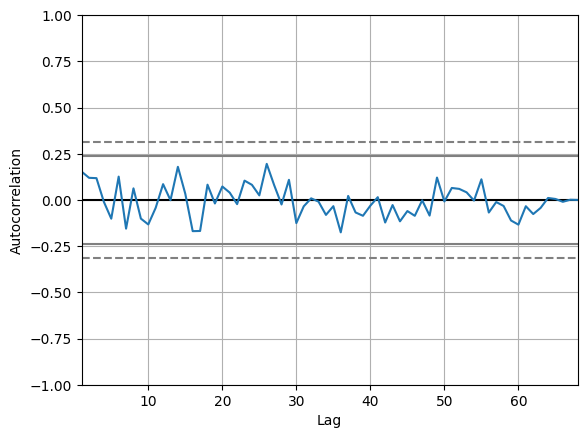

In [37]:
series = imm[['modularity','time_period']].set_index('time_period')
autocorrelation_plot(series)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

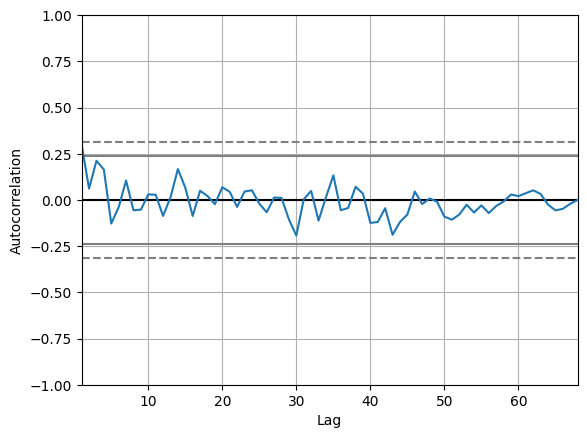

In [38]:
series = clim[['modularity','time_period']].set_index('time_period')
autocorrelation_plot(series)

# Regressions

#### IMMIGRATION – Full Regression

In [127]:
x = imm[['same_left_alignment', 'same_right_alignment','centre_alignment', 'opposite_alignment',
         'media_salience', 'party_salience','gtrend_salience_imm', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = imm.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             modularity   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     1.966
Date:                Fri, 26 Apr 2024   Prob (F-statistic):             0.0302
Time:                        11:54:08   Log-Likelihood:                 93.960
No. Observations:                  68   AIC:                            -147.9
Df Residuals:                      48   BIC:                            -103.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### CLIMATE – Full Regression

In [130]:
x = clim[['same_left_alignment', 'same_right_alignment','centre_alignment', 'opposite_alignment',
         'media_salience', 'party_salience','gtrend_salience_clim', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = clim.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             modularity   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     2.190
Date:                Fri, 26 Apr 2024   Prob (F-statistic):             0.0146
Time:                        11:55:21   Log-Likelihood:                 83.126
No. Observations:                  68   AIC:                            -126.3
Df Residuals:                      48   BIC:                            -81.86
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Run models partially to better understand the significance of different variables

In [16]:
x = imm[[
         'media_salience', 'party_salience','gtrend_salience_imm', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = imm.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
imm_control = model.fit()

x = imm[['same_left_alignment', 
         'media_salience', 'party_salience','gtrend_salience_imm', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = imm.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
imm_same_left = model.fit()

x = imm[['same_left_alignment', 'same_right_alignment',
         'media_salience', 'party_salience','gtrend_salience_imm', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = imm.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
imm_same_right = model.fit()

x = imm[['same_left_alignment', 'same_right_alignment','opposite_alignment', 
         'media_salience', 'party_salience','gtrend_salience_imm', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = imm.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
imm_opposite = model.fit()

x = imm[['same_left_alignment', 'same_right_alignment','opposite_alignment', 'centre_alignment',
         'media_salience', 'party_salience','gtrend_salience_imm', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = imm.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
imm_full = model.fit()



In [17]:
x = clim[[
         'media_salience', 'party_salience','gtrend_salience_clim', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = clim.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
clim_control = model.fit()

x = clim[['same_left_alignment', 
         'media_salience', 'party_salience','gtrend_salience_clim', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = clim.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
clim_same_left = model.fit()

x = clim[['same_left_alignment', 'same_right_alignment',
         'media_salience', 'party_salience','gtrend_salience_clim', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = clim.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
clim_same_right = model.fit()

x = clim[['same_left_alignment', 'same_right_alignment','opposite_alignment', 
         'media_salience', 'party_salience','gtrend_salience_clim', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = clim.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
clim_opposite = model.fit()

x = clim[['same_left_alignment', 'same_right_alignment','opposite_alignment', 'centre_alignment',
         'media_salience', 'party_salience','gtrend_salience_clim', 
         'left_ep', 'left_parliament', 'left_poll',
         'centre_ep', 'centre_parliament', 'centre_poll', 
         'centre-right_ep', 'centre-right_parliament', 'centre-right_poll', 
         'right_ep', 'right_parliament', 'right_poll', 
         'centre-left_ep','centre-left_parliament', 'centre-left_poll',
         'communities_number'
        ]]

y = clim.modularity
x = sm.add_constant(x)

model = sm.OLS(y, x)
clim_full = model.fit()


#### Print the results of the partial regresion to understand the effects of different variables

In [18]:
regression_models = [imm_control, imm_same_left, imm_same_right, imm_opposite, imm_full,
                    clim_control, clim_same_left,clim_same_right,clim_opposite,clim_full]  # Add your models here

# List of model names for printing
model_names = ['Modularity – Immigration','Modularity – Immigration','Modularity – Immigration',
               'Modularity – Immigration','Modularity – Immigration',
               'Modularity – Climate','Modularity – Climate','Modularity – Climate',
               'Modularity – Climate','Modularity – Climate']



In [25]:
def create_coefficient_summary(model, model_name):
    coefficients = pd.DataFrame({
        "Coefficient Name": model.params.index,
        "Coefficient": model.params.values.round(2),
        "Standard Error": model.bse.values.round(2),
        "p-value": model.pvalues.values
    })
    coefficients['Significance'] = ''
    coefficients.loc[coefficients['p-value'] < 0.1, 'Significance'] = '*'
    coefficients.loc[coefficients['p-value'] < 0.05, 'Significance'] = '**'
    coefficients.loc[coefficients['p-value'] < 0.01, 'Significance'] = '***'
    coefficients['Coefficient'] = coefficients.apply(lambda row: f"{row['Coefficient']} {row['Significance']}", axis=1)
    coefficients.drop(columns=['Significance'], inplace=True)
    coefficients.index.name = model_name
    return coefficients

# Iterate over models and print summaries
for i, model in enumerate(regression_models):
    coefficient_summary = create_coefficient_summary(model, model_names[i])
    print('---------------------------------------------------------------')
    print(f"Summary for {model_names[i]}:")
    print(coefficient_summary.to_string(index=False))
    print('rsquared:', model.rsquared)
    print()  # Adding an empty line for better readability between models

    

---------------------------------------------------------------
Summary for Modularity – Immigration:
       Coefficient Name Coefficient  Standard Error  p-value
                  const       1.91             2.84 0.503638
         media_salience    -3.87 **            1.71 0.027677
         party_salience       0.07             0.36 0.844693
    gtrend_salience_imm      -0.07             0.06 0.289063
                left_ep       0.18             0.63 0.773148
        left_parliament      -3.71             6.82 0.588255
              left_poll       0.03             0.37 0.929608
              centre_ep      -0.05             0.36 0.897055
      centre_parliament      -3.31             5.21 0.527536
            centre_poll     0.76 **            0.33 0.024016
        centre-right_ep       0.54             0.59 0.363554
centre-right_parliament      -0.14             0.53 0.789833
      centre-right_poll        0.4             0.49 0.417695
               right_ep       0.63          